In [35]:
import os
import time
import datetime
import json
import requests
import requests.exceptions
import pandas as pd
import polars as pl
from pathlib import Path
from upsetplot import UpSet, from_contents
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

&nbsp;

&nbsp;

# (1) Create output directory

In [36]:
#output directory
direction = "up"
species = "rice"
now = datetime.datetime.now()
result = Path(f'../Data/12_upsetplot_viz/upsetplot_{direction}_{now.strftime("%y%m")}_{species}')
result.mkdir(parents=True, exist_ok=True)

In [37]:
rice_up_idmapping = pl.read_csv(
    "../Data/12_rice_uniprot_idmapping/rice_up_idmapping_all.tsv",
    separator="\t"
)

display(rice_up_idmapping)

From,Entry
str,str
"""Os01g0105800""","""A0A8J8YF34"""
"""Os01g0105800""","""Q657Z2"""
"""Os01g0124000""","""Q5ZCB1"""
"""Os01g0124000""","""Q5ZD53"""
"""Os01g0124100""","""A0A0P0UYB2"""
…,…
"""Os12g0569200""","""C7JA73"""
"""Os12g0569200""","""Q2QND9"""
"""Os12g0600100""","""Q0IM43"""


In [38]:
rice_up_genes = rice_up_idmapping.select(
    [
        "From"
    ]
).unique()

&nbsp;

&nbsp;

## (2) Gene Ontology information

- GOSlimのタームであるGO:0006950 response to stressがアノテーションされているか
- アノテーションされている場合、マッピングされたGOのエビデンスコードがIEAのみかを確認

In [44]:
go_mapping = pl.read_csv(
    "../Data/09_goatools/ensembl/rice_go_annotation_r58.tsv",
    separator="\t"
).rename(
    {
        "Gene stable ID": "From"
    }
)

rice_up_go = rice_up_genes.join(
    go_mapping,
    on="From",
    how="left",
    coalesce=True
).filter(
    pl.col("GO term accession") == "GO:0009408"
)

rice_up_golist = rice_up_go.select(
    [
        "From"
    ]
).unique()

display(rice_up_golist)

From
str
"""Os01g0136200"""
"""Os06g0219500"""
"""Os04g0445100"""
"""Os02g0782500"""
"""Os03g0266300"""
…
"""Os03g0266900"""
"""Os03g0245800"""
"""Os03g0267200"""


In [1]:
# contents_v1 = {
#     "rice upregulated genes": rice_up_genes.to_series().to_list(),
#     "response to heat": rice_up_golist.to_series().to_list()
# }

# for key, value in contents_v1.items():
#     print(f"{key}: {len(value)}")

# upset_data_v1 = from_contents(contents_v1)
# display(upset_data_v1)
                     

In [2]:
# upset_plot = UpSet(
#     upset_data_v1,
#     orientation='horizontal',
#     show_counts="{:d}",
#     subset_size='count',
#     include_empty_subsets = False
# )

# upset_plot.style_subsets(
#     present=["response to heat"],
#     facecolor="orangered"
# )

# fig = plt.figure(figsize=(14, 8), dpi=500)
# upset_plot.plot(fig=fig)
# plt.show()

&nbsp;

&nbsp;

&nbsp;

## (3) InterPro information

In [9]:
uniprot_id = rice_up_idmapping.join(
    pl.read_csv(
        "../Data/Data_uniprot/rice_up_idmapping_20250524.tsv", 
        separator="\t"
    ).drop("From"),
    on="Entry",
    how="left",
    coalesce=True
).select(
    [
        "From",
        "Entry",
        "InterPro"
    ]
)

display(uniprot_id)

From,Entry,InterPro
str,str,str
"""Os01g0105800""","""A0A8J8YF34""","""IPR050322;IPR000361;IPR016092;…"
"""Os01g0105800""","""Q657Z2""","""IPR050322;IPR000361;IPR016092;…"
"""Os01g0124000""","""Q5ZCB1""","""IPR035995;IPR000877;"""
"""Os01g0124000""","""Q5ZD53""","""IPR035995;IPR000877;"""
"""Os01g0124100""","""A0A0P0UYB2""","""IPR035995;IPR000877;"""
…,…,…
"""Os12g0569200""","""C7JA73""",null
"""Os12g0569200""","""Q2QND9""",null
"""Os12g0600100""","""Q0IM43""","""IPR002110;IPR036770;IPR051616;…"


In [12]:
uniprot_id_gene = uniprot_id.group_by("From").agg(
    pl.col("InterPro")
).with_columns(
    pl.when(
        pl.col("InterPro").list.eval(pl.element().is_not_null()).list.all()
    )
    .then(
        pl.lit("InterPro")
    )
    .otherwise(None)
    .alias("InterPro_exist")
).filter(
    pl.col("InterPro_exist").is_not_null()
).drop(
    {
        "InterPro",
        "InterPro_exist"
    }
)

display(uniprot_id_gene)

From
str
"""Os05g0457000"""
"""Os03g0285700"""
"""Os09g0425200"""
"""Os05g0460000"""
"""Os07g0638300"""
…
"""Os02g0125300"""
"""Os05g0435400"""
"""Os07g0644100"""


&nbsp;

&nbsp;

&nbsp;

## Upsetplot visualization (2)

In [3]:
# contents_v2 = {
#     "rice upregulated genes": rice_up_genes.to_series().to_list(),
#     "response to heat": rice_up_golist.to_series().to_list(),
#     "InterPro": uniprot_id_gene.to_series().to_list()
# }

# for key, value in contents_v2.items():
#     print(f"{key}: {len(value)}")

# upset_data_v2 = from_contents(contents_v2)
# display(upset_data_v2)
                     

In [4]:
# upset_plot = UpSet(
#     upset_data_v2,
#     orientation='horizontal',
#     show_counts="{:d}",
#     subset_size='count',
#     include_empty_subsets = False
# )

# upset_plot.style_subsets(
#     present=["response to heat"],
#     facecolor="orangered"
# )

# fig = plt.figure(figsize=(14, 8), dpi=500)
# upset_plot.plot(fig=fig)
# plt.show()

&nbsp;

&nbsp;

&nbsp;

## (4) Get sequence similarity informartion from ensembl pan-homology

In [55]:
rice_up_pan_homology_9606 = pl.read_csv(
    "../Data/13_rice_pan_homology/rice_up_panhomology_9606_concat.tsv",
    separator="\t"
).select(
    [
        "From"
    ]
).unique()

display(rice_up_pan_homology_9606)

From
str
"""Os06g0159900"""
"""Os08g0117900"""
"""Os03g0218500"""
"""Os02g0134300"""
"""Os02g0115900"""
…
"""Os03g0245800"""
"""Os10g0462900"""
"""Os05g0373900"""


In [56]:
rice_up_pan_homology_10090 = pl.read_csv(
    "../Data/13_rice_pan_homology/rice_up_panhomology_10090_concat.tsv",
    separator="\t"
).select(
    [
        "From"
    ]
).unique()

display(rice_up_pan_homology_10090)

From
str
"""Os02g0580500"""
"""Os03g0785900"""
"""Os06g0195800"""
"""Os02g0164000"""
"""Os10g0520700"""
…
"""Os11g0244200"""
"""Os08g0546400"""
"""Os01g0699400"""


In [57]:
contents_v3 = {
    "rice upregulated genes": rice_up_genes.to_series().to_list(),
    "response to heat": rice_up_golist.to_series().to_list(),
    "InterPro": uniprot_id_gene.to_series().to_list(),
    "pan-homology human": rice_up_pan_homology_9606.to_series().to_list(),
    "pan-homology mouse": rice_up_pan_homology_10090.to_series().to_list()
}

for key, value in contents_v3.items():
    print(f"{key}: {len(value)}")

upset_data_v3 = from_contents(contents_v3)
display(upset_data_v3)

rice upregulated genes: 367
response to heat: 21
InterPro: 251
pan-homology human: 112
pan-homology mouse: 112


/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
rice upregulated genes response to heat InterPro pan-homology human pan-homology mouse              
True                   True             True     True               True                Os11g0244200
                       False            True     True               True                Os05g0460000
                                                 False              False               Os05g0407100
                                                 True               True                Os03g0131800
                                                                    True                Os01g0183300
...                                                                                              ...
                                        False    False              False               Os09g0120033
                                        True     False              False               Os03g0286900
                                        False    False              False               Os02g0542450
                                                                    False               Os03g0296200
                                        True     True               True                Os01g0860601

[367 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

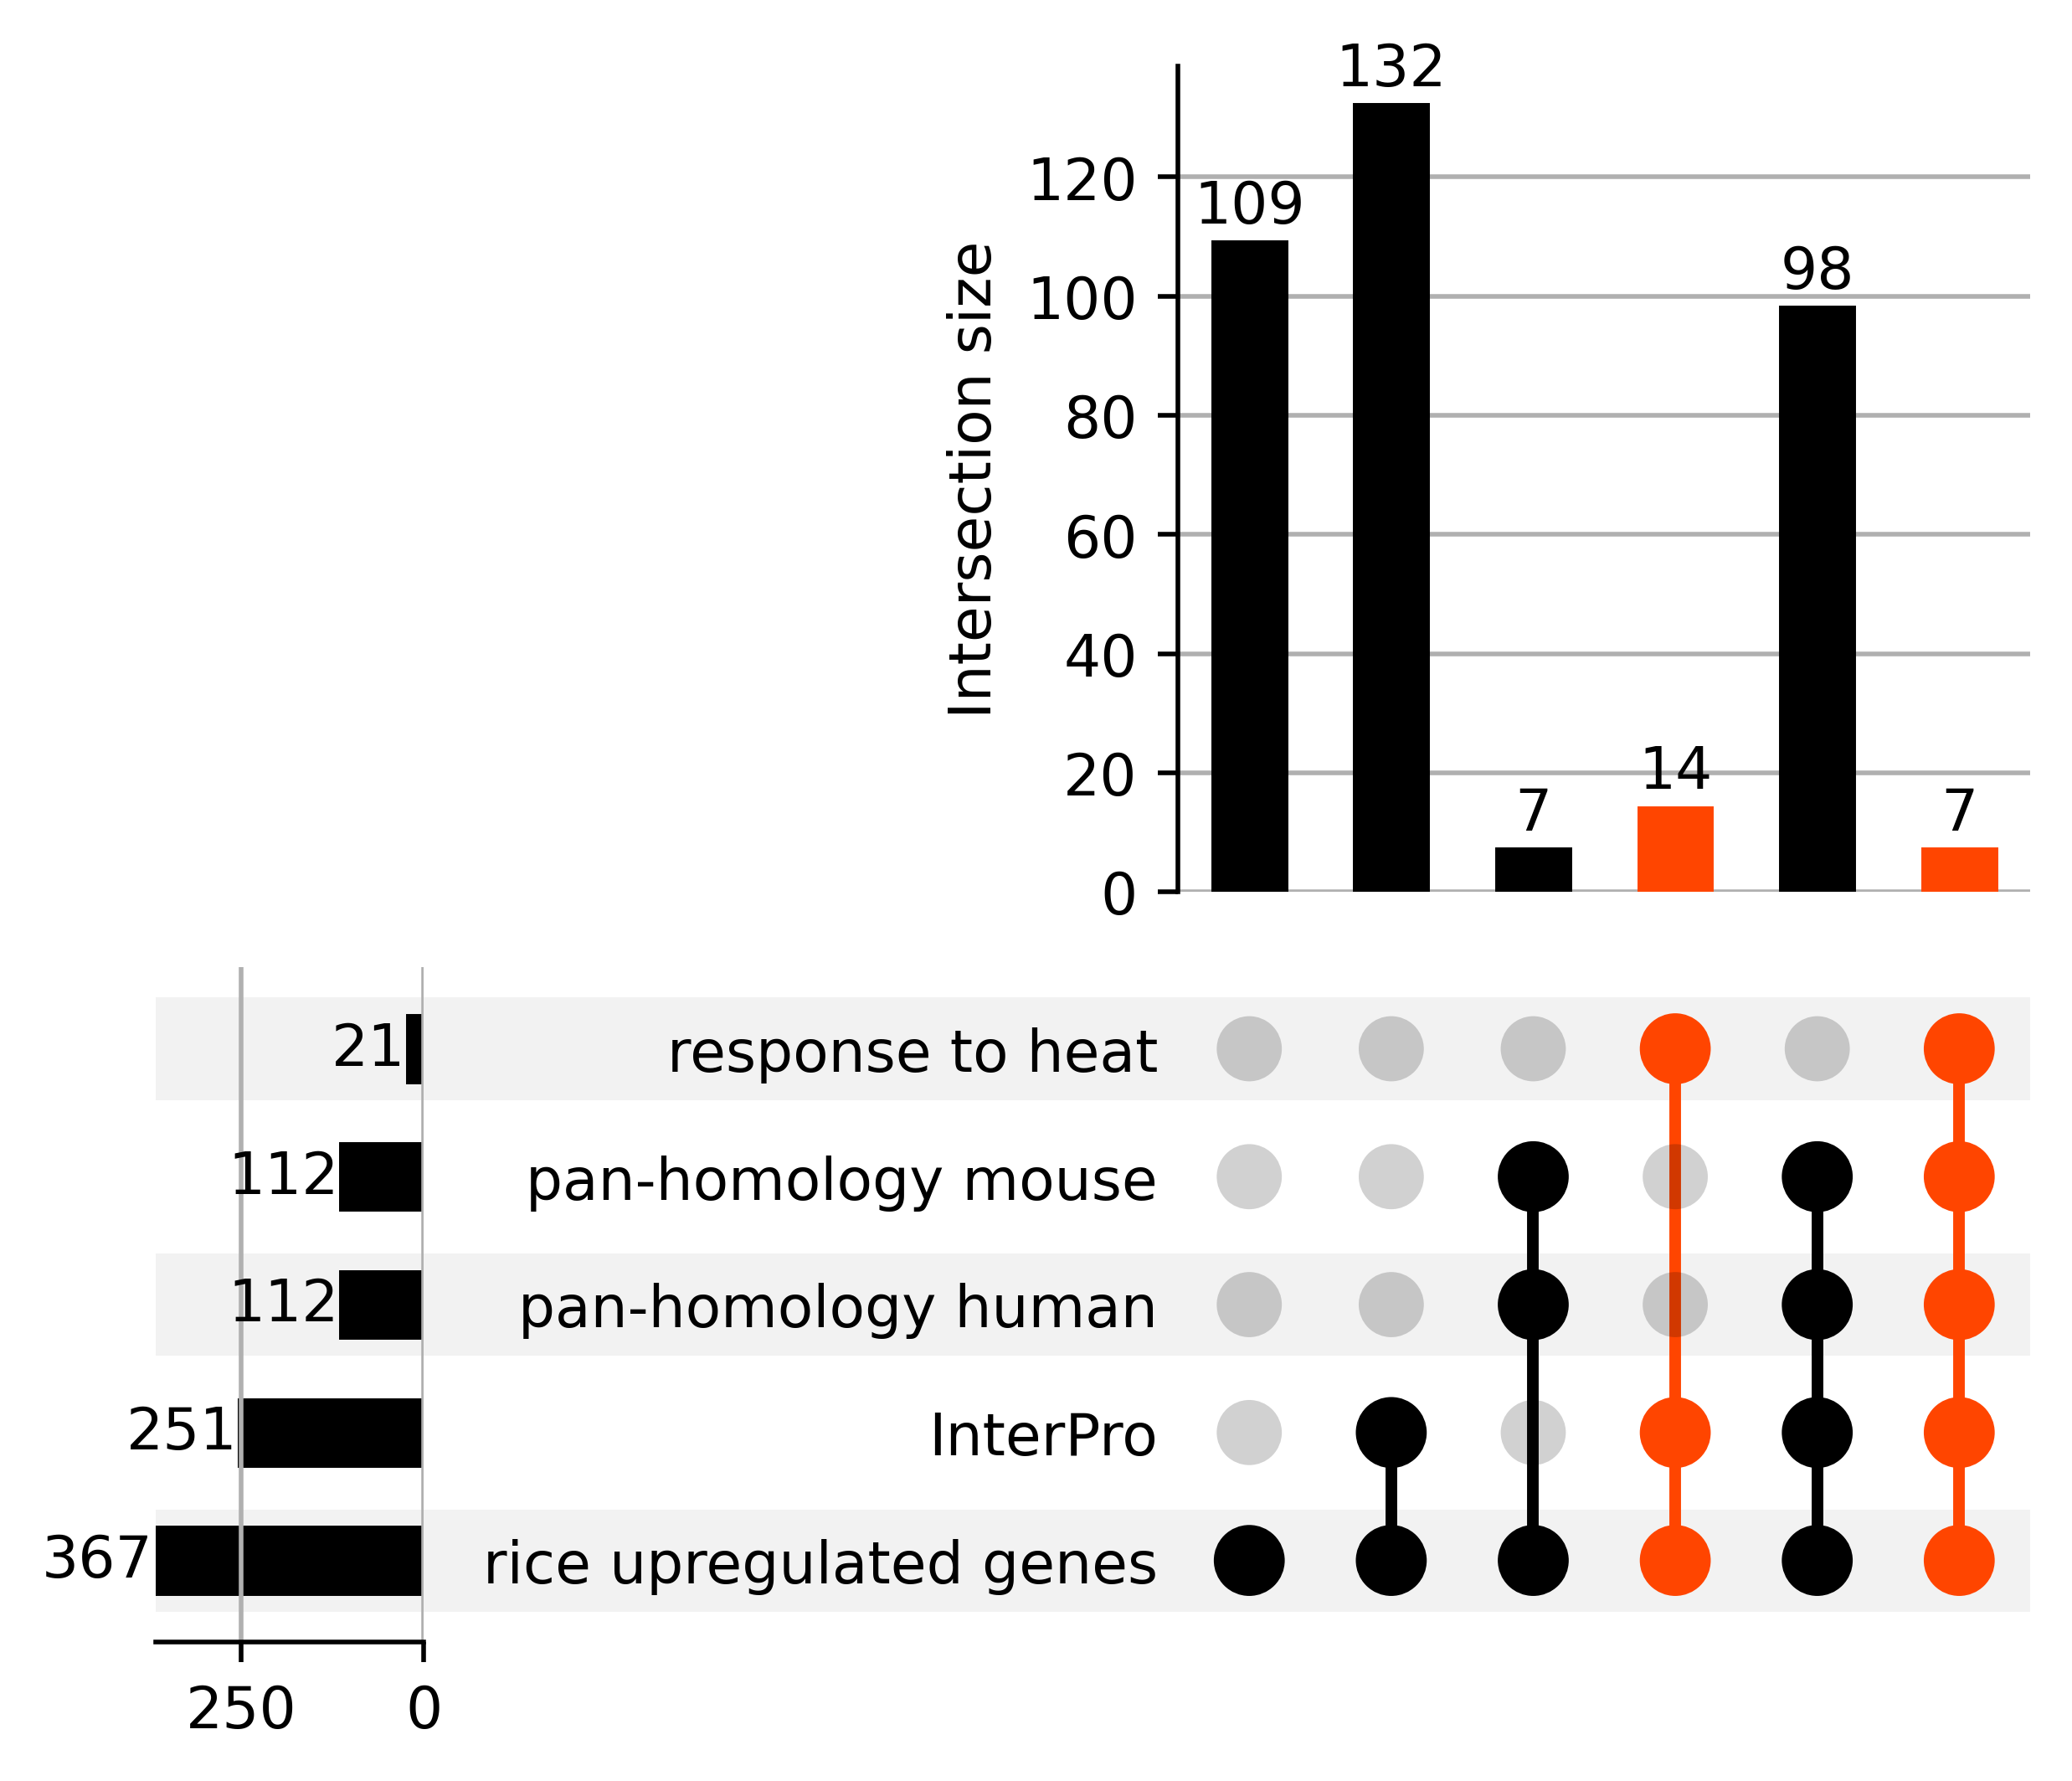

In [58]:
upset_plot = UpSet(
    upset_data_v3,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(
    present=["response to heat"],
    facecolor="orangered"
)

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()